In [1]:
from information_geometry import *

# **Information Geometry and Statistical Manifolds**
## *Noeloikeau Charlot 9/30/22*

This library implements *information geometry*, a framework for quantifying the geometry of probability distributions. See `README.md` for a lengthy discussion on what this means, and `information_geometry.py` for the primary code.

In brief, the class of interest is *StatisticalManifold*, which numerically calculates and stores the properties associated with an input probability density function `f`.



## Normal Distribution
The Normal or Gaussian distribution is given by

>   $a=(\mu,\sigma)$

>   $f(x,a) = \exp[(\frac{x-\mu}{\sigma})^2]$ 

where $a$ is the parameter vector giving the mean and standard deviation, and $f$ is the un-normalized probability density function (PDF). The analytic solution to the normalization factor is $f\rightarrow f\cdot[\sigma\sqrt{2\pi}]^{-1}$. 

We can normalize numerically by integrating over the points in the domain for which the function is not zero (its support). Consider the parameter vector $a=(0,1)$. To within small error the support of the normal distribution lies within $5\sigma$ of the mean $\mu=0$. Thus, we integrate over $x\in[-5,5]$ using $10^{4}$ evenly spaced points and divide by the sum with `normalize=True`:

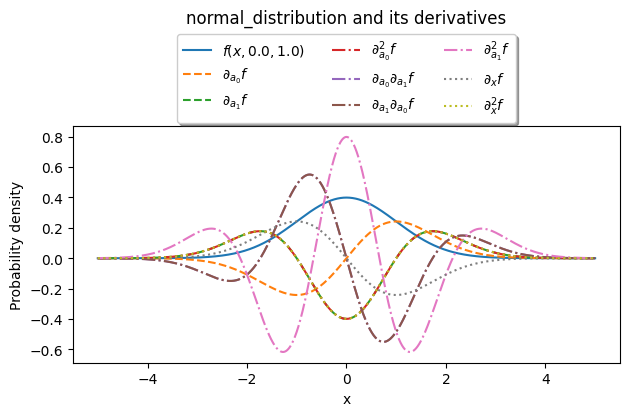

In [2]:
x=np.linspace(-5,5,10000) # data
a=np.array([0,1.0]) # 0 mean, 1 std
sm=StatisticalManifold(normal_distribution,x=x,a=a,normalize=True)
sm.plot()

The `StatisticalManifold` class automatically calculates the result of function $y=f(x,a)$ and its derivatives with respect to the parameters $a$ and data $x$. They are stored in array attributes such as `x`, `a`, `jx`, `ha`, which are the Jacobian w.r.t `x`, Hessian w.r.t `a`, etc.:

In [3]:
print( list( reversed( list( vars(sm).keys() ))))

['gamma', 'dg', 'ginv', 'g', 'ha', 'hx', 'ja', 'jx', 'y', 'fname', 'da_matrix', 'dx_matrix', 'a_dim', 'a_pts', 'x_dim', 'x_pts', 'x_bounds', 'replaces_inf', 'f_shape', 'f_bounds', 'f', 'a_bounds', 'normalize', 'da', 'dx', 'a', 'x']


Note how $\partial_{x}f = -\partial_{\mu}f$. This is due to the symmetry of the argument in the normal distribution $(\frac{x-\mu}{\sigma})$. We can check this numerically as follows:




In [4]:
np.allclose(sm.jx, -sm.ja[0])


True

Further note that the cross-partials commute $\partial_{a_{0}}\partial_{a_{1}}f=\partial_{a_{1}}\partial_{a_{0}}f$, and are represented as an odd function with curvature in the sample space `x`.

In order to compute the `a` curvature, we need the logarithm of the probabilities. These transform as follows:

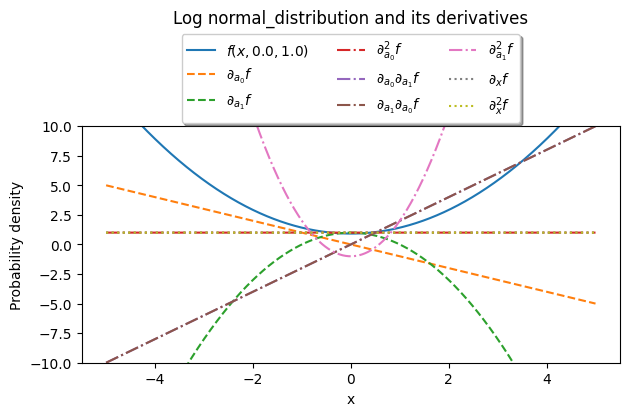

In [5]:
sm.plot(log=True, ylim=[-10,10])

The logPDF is simply a parabola, since $\log[f]=(\frac{x-\mu}{\sigma})^{2}$. Note how the cross-partial is now a linear function. These functions are used to construct the geodesics in parameter space as follows.

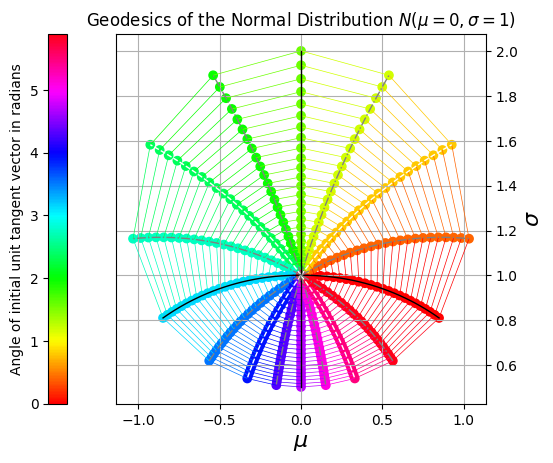

In [6]:
#compute paths of length T using N tangent vectors in a circle of radius R at point a
pos1=sm.geodesics(a=sm.a[0],N=16,T=25,R=1)
sm.plot_geodesics(pos1,
    title=r'Geodesics of the Normal Distribution $N(\mu=0,\sigma=1)$',
    xlabel=r'$\mu$',
    ylabel=r'$\sigma$',
    fontsize=16)

As each geodesic propagates, its path is curved by the space, as shown by deformation of the path starting from the initially orthogonal $(\mu,\sigma)$ axes, i.e., the black lines at point (0,1).  

The points are solutions to a geodesic equation starting from the given angle (color). The lines connecting points are first-order approximations to the level sets of the affine parameter. In general relativity these would be slices of equal proper time for which observers traveling along each geodesic record the same number of ticks of an identical clock.

## Beta Distribution
> Defined on unit interval with two positive parameters.

> https://en.wikipedia.org/wiki/Beta_distribution

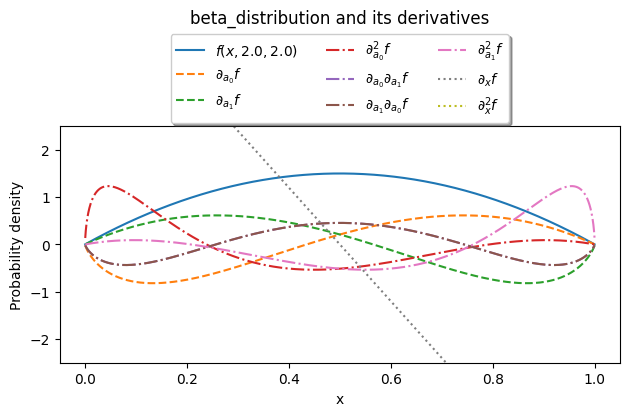

In [7]:
bm=StatisticalManifold(beta_distribution,normalize=True,a=np.array([2.0,2.0]))
bm.plot(ylim=[-2.5,2.5])

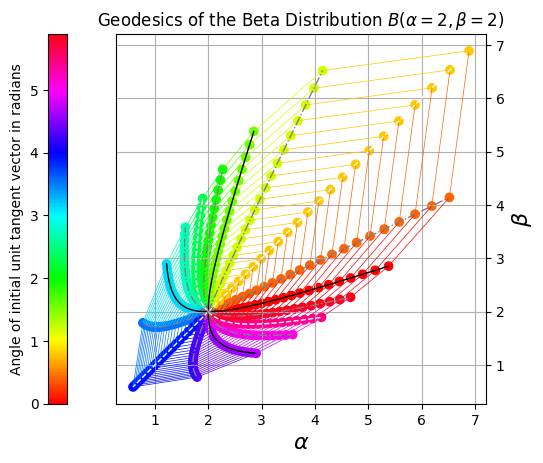

In [8]:
pos2=bm.geodesics()
bm.plot_geodesics(pos2,
    title=r'Geodesics of the Beta Distribution $B(\alpha=2,\beta=2)$',
    xlabel=r'$\alpha$',
    ylabel=r'$\beta$',
    fontsize=16)

## Defining a Statistical Manifold
> You can define your own SMs as follows. Consider the Exponentiated generalized Pareto distribution, defined at https://en.wikipedia.org/wiki/Generalized_Pareto_distribution#Exponentiated_generalized_Pareto_distribution

In [9]:
#The relevant terms are shown in the wikipedia page
@njit
def pareto_distribution(x,a):
     sigma,zeta=a[0],a[1]
     sigmainv=1./sigma
     return np.exp(x)*sigmainv*(1.+zeta*np.exp(x)*sigmainv)**(-1./zeta-1.)
    
pareto_distribution.f_shape = (1,)
pareto_distribution.a = np.array([1.0,5.0]) #default point
pareto_distribution.x = np.linspace(-10,25,10000) #default x axis
pareto_distribution.x_bounds = real_line
pareto_distribution.a_bounds = np.array([positives,positives])
pareto_distribution.f_bounds = positives

pm=StatisticalManifold(pareto_distribution,normalize=True)

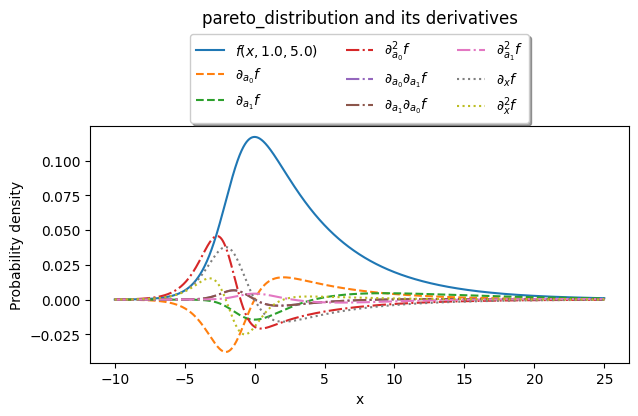

In [10]:
pm.plot()

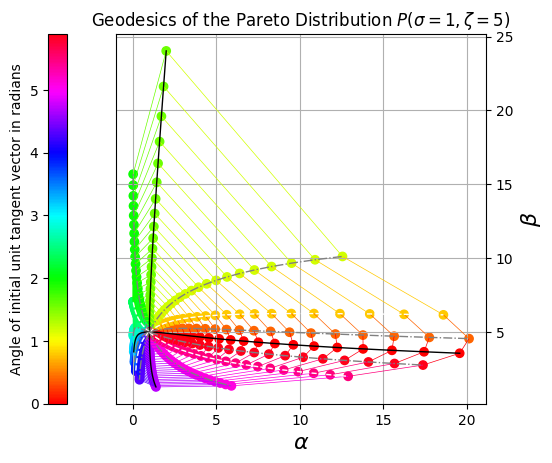

In [11]:
pos3=pm.geodesics()
pm.plot_geodesics(pos3,
    title=r'Geodesics of the Pareto Distribution $P(\sigma=1,\zeta=5)$',
    xlabel=r'$\alpha$',
    ylabel=r'$\beta$',
    fontsize=16)

In [12]:
pm.positive_definite(pm.g)

True

Thus, the above is a valid Riemannian manifold. As such, the curvature tensor and other geometric quantities of interest can be calculated from e.g. the metric at this point and its derivative:


In [13]:
print(pm.g)
print('\n')
print(pm.dg)

[[0.09111635 0.01421633]
 [0.01421633 0.02508219]]


[[[-0.18214212 -0.01436711]
  [-0.01436711 -0.00065162]]

 [[-0.01627688 -0.00567633]
  [-0.00567633 -0.01187703]]]


In [14]:
pm.christoffel()

(array([[0.09111635, 0.01421633],
        [0.01421633, 0.02508219]]),
 array([[12.03968091, -6.82396647],
        [-6.82396647, 43.73667882]]),
 array([[[-0.18214212, -0.01436711],
         [-0.01436711, -0.00065162]],
 
        [[-0.01627688, -0.00567633],
         [-0.00567633, -0.01187703]]]),
 array([[[-1.05396227, -0.09576091],
         [-0.09576091, -0.02389429]],
 
        [[ 0.34904451,  0.0412866 ],
         [ 0.0412866 , -0.22321925]]]))